In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/MusicProject/Processed


label_map.json	X.npy  y.npy


In [4]:
import numpy as np

X = np.load('/content/drive/MyDrive/MusicProject/Processed/X.npy')
y = np.load('/content/drive/MyDrive/MusicProject/Processed/y.npy')

print(X.shape)
print(y.shape)


(5600, 128, 128)
(5600,)


In [5]:
# Right now, X looks like this:
# (number_of_samples, height, width)
# Example: (5600, 128, 128)

# CNNs don't like "flat images".
# They expect a channel dimension, just like:
# - RGB images → 3 channels
# - Grayscale images → 1 channel

# Our spectrograms are grayscale,
# so we manually add a "1" channel at the end.

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Always print shape after reshaping.
# This is a sanity check to make sure nothing broke.
print("New X shape:", X.shape)


New X shape: (5600, 128, 128, 1)


In [6]:
# Right now, y contains labels like:
# "Guitar", "Flute", "Bass", etc.

# Neural networks DO NOT understand text.
# They only understand numbers.

# LabelEncoder converts each instrument name
# into a unique integer.
# Example:
# Guitar → 3
# Flute  → 1
# Bass   → 0

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Fit = learn all unique labels
# Transform = convert labels to numbers
y_encoded = encoder.fit_transform(y)

# Print the mapping so we KNOW what number means what
print("Instrument classes (label order):")
print(encoder.classes_)

print("Encoded labels shape:", y_encoded.shape)


Instrument classes (label order):
[0 1 2 3 4 5 6 7]
Encoded labels shape: (5600,)


In [7]:
# If we train and test on the same data,
# the model might just MEMORIZE instead of LEARN.

# So we hide 20% of the data from the model.
# This hidden data is called the validation set.

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.2,      # 20% for validation
    random_state=42,    # makes results reproducible
    stratify=y_encoded  # keeps class balance intact
)

# Print shapes to verify split worked correctly
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)


Training data shape: (4480, 128, 128, 1) (4480,)
Validation data shape: (1120, 128, 128, 1) (1120,)


In [8]:
# TensorFlow is our deep learning engine
# Keras is the high-level API we use to build the model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)

# Sequential model = straight pipeline (perfect for baseline CNN)
model = Sequential()

# ---- Explicit Input Layer ----
# This tells the model exactly what ONE input looks like.
# Shape = (height, width, channels)
# Using Input() avoids Keras warnings and is best practice.

model.add(Input(shape=(128, 128, 1)))

# ---- Convolution Block 1 ----
# Learns simple visual patterns in spectrograms
# like edges, frequency bands, and short transients

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- Convolution Block 2 ----
# Learns more complex combinations of patterns

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ---- Flatten ----
# Converts 2D feature maps into a 1D vector
# so Dense layers can work with it

model.add(Flatten())

# ---- Dense Layer ----
# This is the "thinking" part of the network

model.add(Dense(128, activation='relu'))

# Dropout = randomly turn off neurons during training
# Helps prevent overfitting (memorization)

model.add(Dropout(0.5))

# ---- Output Layer ----
# One neuron per instrument class
# Softmax turns outputs into probabilities

model.add(Dense(len(set(y_encoded)), activation='softmax'))


In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,776 (28.20 MB)

 Trainable params: 7,392,776 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import tensorflow as tf
print("GPU devices:", tf.config.list_physical_devices('GPU'))


GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
# This is where the model actually learns.
# It looks at spectrograms, makes predictions,
# checks how wrong it was, and updates itself.

history = model.fit(
    X_train, y_train,
    epochs=20,              # mentor-recommended baseline
    batch_size=32,          # stable + GPU-friendly
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2061 - loss: 36.9809 - val_accuracy: 0.3625 - val_loss: 1.6510
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3409 - loss: 1.7153 - val_accuracy: 0.4670 - val_loss: 1.3832
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4334 - loss: 1.4404 - val_accuracy: 0.5089 - val_loss: 1.2637
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4879 - loss: 1.3399 - val_accuracy: 0.5304 - val_loss: 1.2440
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5116 - loss: 1.3126 - val_accuracy: 0.5705 - val_loss: 1.1734
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5656 - loss: 1.1531 - val_accuracy: 0.6054 - val_loss: 1.0956
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6028 - loss: 1.0719 - val_accuracy: 0.6402 - val_loss: 0.9983
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6348 - loss: 0.9839 - val_acc

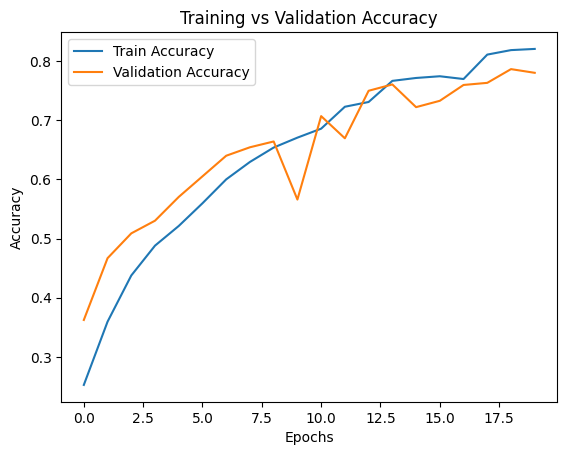

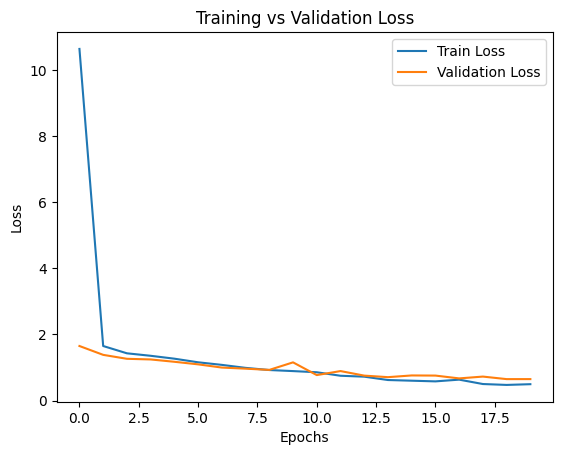

In [13]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Loss plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


<Figure size 800x800 with 0 Axes>

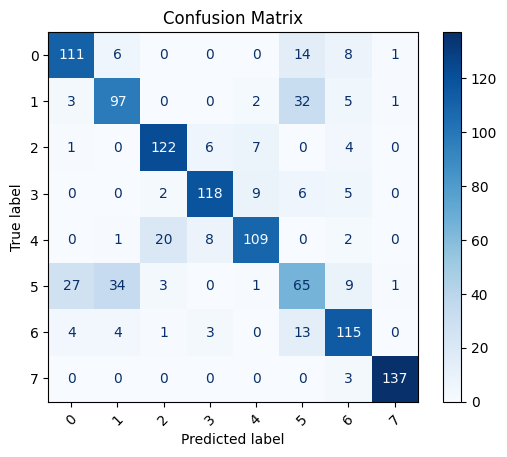

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get model predictions
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=encoder.classes_
)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [17]:
model.save('instrunet_model_v1.keras')


In [18]:
!mv instrunet_model_v1.keras /content/drive/MyDrive/MusicProject
